# Machine Learning

## XgBoost

### Jorge de Toro, Juan A. Ortíz

### Predicción series temporales by month

# XgBoost

¿Cuándo se debe usar XGBoost?

1.Para datasets grandes (más de 1000 observaciones, esto se debe a que el boosting mejora con iteraciones) y que el número de variables sea menor que el número de observaciones.

2.Para problemas con una mezcla de variables categóricas y numéricas, o sólo numéricas (al contrario que la regresión lineal, el KNN o el K-Means, este algoritmo sí que acepta variables categóricas tal cual están).


In [33]:
#importamos las librerías necesarias
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import itertools
import multiprocessing

from dateutil import relativedelta
from monthdelta import monthdelta
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance



In [34]:
#carga de datos
df = pd.read_csv('C:/Users/jorge/El Corte Inglés, S.A/Otb y el master - Documentos/VentaMes2017-2019.csv',';',parse_dates=True)

df['Fecha Venta'] = pd.to_datetime(df['Fecha Venta'])
df=df.dropna()

#set date as index column. (required in time series)
df = df.set_index('Fecha Venta')

print('Shape of data',df.shape)
print(df.dtypes)
df.head()

Shape of data (36, 1)
Unidades Vendidas    int64
dtype: object


,Unidades Vendidas
Fecha Venta,
2017-01-01,94158
2017-02-01,30152
2017-03-01,38901
2017-04-01,58229
2017-05-01,59880


Hay que reestructurar este conjunto de datos de series temporales para ajustarlo a un problema de aprendizaje supervisado. Para ello utilizaremos el valor en el paso de tiempo anterior para predecir el valor en el siguiente paso de tiempo.

In [35]:
df['Sale_LastMonth'] = df['Unidades Vendidas'].shift(+1)
df['Sale_2Monthsback'] = df['Unidades Vendidas'].shift(+2)
df['Sale_3Monthsback'] = df['Unidades Vendidas'].shift(+3)
df['Sale_4Monthsback'] = df['Unidades Vendidas'].shift(+4)
df['Sale_5Monthsback'] = df['Unidades Vendidas'].shift(+5)
df['Sale_6Monthsback'] = df['Unidades Vendidas'].shift(+6)
df['Sale_7Monthsback'] = df['Unidades Vendidas'].shift(+7)
df['Sale_8Monthsback'] = df['Unidades Vendidas'].shift(+8)
df['Sale_9Monthsback'] = df['Unidades Vendidas'].shift(+9)
df['Sale_10Monthsback'] = df['Unidades Vendidas'].shift(+10)
df['Sale_11Monthsback'] = df['Unidades Vendidas'].shift(+11)
df['Sale_12Monthsback'] = df['Unidades Vendidas'].shift(+12)

df=df.dropna()
df.head(10)

,Unidades Vendidas,Sale_LastMonth,Sale_2Monthsback,Sale_3Monthsback,Sale_4Monthsback,Sale_5Monthsback,Sale_6Monthsback,Sale_7Monthsback,Sale_8Monthsback,Sale_9Monthsback,Sale_10Monthsback,Sale_11Monthsback,Sale_12Monthsback
Fecha Venta,,,,,,,,,,,,,
2018-01-01,80549,100580.0,114898.0,45831.0,64198.0,66329.0,56861.0,57168.0,59880.0,58229.0,38901.0,30152.0,94158.0
2018-02-01,38136,80549.0,100580.0,114898.0,45831.0,64198.0,66329.0,56861.0,57168.0,59880.0,58229.0,38901.0,30152.0
2018-03-01,36001,38136.0,80549.0,100580.0,114898.0,45831.0,64198.0,66329.0,56861.0,57168.0,59880.0,58229.0,38901.0
2018-04-01,43879,36001.0,38136.0,80549.0,100580.0,114898.0,45831.0,64198.0,66329.0,56861.0,57168.0,59880.0,58229.0
2018-05-01,46627,43879.0,36001.0,38136.0,80549.0,100580.0,114898.0,45831.0,64198.0,66329.0,56861.0,57168.0,59880.0
2018-06-01,44648,46627.0,43879.0,36001.0,38136.0,80549.0,100580.0,114898.0,45831.0,64198.0,66329.0,56861.0,57168.0
2018-07-01,46304,44648.0,46627.0,43879.0,36001.0,38136.0,80549.0,100580.0,114898.0,45831.0,64198.0,66329.0,56861.0
2018-08-01,46556,46304.0,44648.0,46627.0,43879.0,36001.0,38136.0,80549.0,100580.0,114898.0,45831.0,64198.0,66329.0
2018-09-01,61019,46556.0,46304.0,44648.0,46627.0,43879.0,36001.0,38136.0,80549.0,100580.0,114898.0,45831.0,64198.0


In [36]:
#convertimos el dataframe en una matriz
x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,y = df['Sale_LastMonth'],df['Sale_2Monthsback'],df['Sale_3Monthsback'],df['Sale_4Monthsback'],df['Sale_5Monthsback'],df['Sale_6Monthsback'],df['Sale_7Monthsback'],df['Sale_8Monthsback'],df['Sale_9Monthsback'],df['Sale_10Monthsback'],df['Sale_11Monthsback'],df['Sale_12Monthsback'],df['Unidades Vendidas']

x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,y=np.array(x1),np.array(x2),np.array(x3),np.array(x4),np.array(x5),np.array(x6),np.array(x7),np.array(x8),np.array(x9),np.array(x10),np.array(x11),np.array(x12),np.array(y)

x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,y=x1.reshape(-1,1),x2.reshape(-1,1),x3.reshape(-1,1),x4.reshape(-1,1),x5.reshape(-1,1),x6.reshape(-1,1),x7.reshape(-1,1),x8.reshape(-1,1),x9.reshape(-1,1),x10.reshape(-1,1),x11.reshape(-1,1),x12.reshape(-1,1),y.reshape(-1,1)

final_x=np.concatenate((x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12),axis=1)

print(final_x)

print(final_x.shape)

[[100580. 114898.  45831.  64198.  66329.  56861.  57168.  59880.  58229.
   38901.  30152.  94158.]
 [ 80549. 100580. 114898.  45831.  64198.  66329.  56861.  57168.  59880.
   58229.  38901.  30152.]
 [ 38136.  80549. 100580. 114898.  45831.  64198.  66329.  56861.  57168.
   59880.  58229.  38901.]
 [ 36001.  38136.  80549. 100580. 114898.  45831.  64198.  66329.  56861.
   57168.  59880.  58229.]
 [ 43879.  36001.  38136.  80549. 100580. 114898.  45831.  64198.  66329.
   56861.  57168.  59880.]
 [ 46627.  43879.  36001.  38136.  80549. 100580. 114898.  45831.  64198.
   66329.  56861.  57168.]
 [ 44648.  46627.  43879.  36001.  38136.  80549. 100580. 114898.  45831.
   64198.  66329.  56861.]
 [ 46304.  44648.  46627.  43879.  36001.  38136.  80549. 100580. 114898.
   45831.  64198.  66329.]
 [ 46556.  46304.  44648.  46627.  43879.  36001.  38136.  80549. 100580.
  114898.  45831.  64198.]
 [ 61019.  46556.  46304.  44648.  46627.  43879.  36001.  38136.  80549.
  100580. 114898.

In [37]:
#División de los datos entre train y test
#usaremos train_test_split para ello.

#X = df.iloc[:, 1:] 
#y = df.iloc[:,0]
X = df.iloc[:, 0:-1] 
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state=123)

In [38]:
X

,Unidades Vendidas,Sale_LastMonth,Sale_2Monthsback,Sale_3Monthsback,Sale_4Monthsback,Sale_5Monthsback,Sale_6Monthsback,Sale_7Monthsback,Sale_8Monthsback,Sale_9Monthsback,Sale_10Monthsback,Sale_11Monthsback
Fecha Venta,,,,,,,,,,,,
2018-01-01,80549,100580.0,114898.0,45831.0,64198.0,66329.0,56861.0,57168.0,59880.0,58229.0,38901.0,30152.0
2018-02-01,38136,80549.0,100580.0,114898.0,45831.0,64198.0,66329.0,56861.0,57168.0,59880.0,58229.0,38901.0
2018-03-01,36001,38136.0,80549.0,100580.0,114898.0,45831.0,64198.0,66329.0,56861.0,57168.0,59880.0,58229.0
2018-04-01,43879,36001.0,38136.0,80549.0,100580.0,114898.0,45831.0,64198.0,66329.0,56861.0,57168.0,59880.0
2018-05-01,46627,43879.0,36001.0,38136.0,80549.0,100580.0,114898.0,45831.0,64198.0,66329.0,56861.0,57168.0
2018-06-01,44648,46627.0,43879.0,36001.0,38136.0,80549.0,100580.0,114898.0,45831.0,64198.0,66329.0,56861.0
2018-07-01,46304,44648.0,46627.0,43879.0,36001.0,38136.0,80549.0,100580.0,114898.0,45831.0,64198.0,66329.0
2018-08-01,46556,46304.0,44648.0,46627.0,43879.0,36001.0,38136.0,80549.0,100580.0,114898.0,45831.0,64198.0
2018-09-01,61019,46556.0,46304.0,44648.0,46627.0,43879.0,36001.0,38136.0,80549.0,100580.0,114898.0,45831.0


In [39]:
X_test

,Unidades Vendidas,Sale_LastMonth,Sale_2Monthsback,Sale_3Monthsback,Sale_4Monthsback,Sale_5Monthsback,Sale_6Monthsback,Sale_7Monthsback,Sale_8Monthsback,Sale_9Monthsback,Sale_10Monthsback,Sale_11Monthsback
Fecha Venta,,,,,,,,,,,,
2018-06-01,44648,46627.0,43879.0,36001.0,38136.0,80549.0,100580.0,114898.0,45831.0,64198.0,66329.0,56861.0
2019-09-01,58027,45341.0,44742.0,42994.0,46596.0,37094.0,37323.0,32295.0,89955.0,97409.0,89998.0,44042.0
2019-10-01,42642,58027.0,45341.0,44742.0,42994.0,46596.0,37094.0,37323.0,32295.0,89955.0,97409.0,89998.0
2019-07-01,44742,42994.0,46596.0,37094.0,37323.0,32295.0,89955.0,97409.0,89998.0,44042.0,61019.0,46556.0
2019-04-01,37094,37323.0,32295.0,89955.0,97409.0,89998.0,44042.0,61019.0,46556.0,46304.0,44648.0,46627.0


In [40]:
y

Fecha Venta
2018-01-01     94158.0
2018-02-01     30152.0
2018-03-01     38901.0
2018-04-01     58229.0
2018-05-01     59880.0
2018-06-01     57168.0
2018-07-01     56861.0
2018-08-01     66329.0
2018-09-01     64198.0
2018-10-01     45831.0
2018-11-01    114898.0
2018-12-01    100580.0
2019-01-01     80549.0
2019-02-01     38136.0
2019-03-01     36001.0
2019-04-01     43879.0
2019-05-01     46627.0
2019-06-01     44648.0
2019-07-01     46304.0
2019-08-01     46556.0
2019-09-01     61019.0
2019-10-01     44042.0
2019-11-01     89998.0
2019-12-01     97409.0
Name: Sale_12Monthsback, dtype: float64

In [41]:
#hay que ajustar los parámetros de xgb para ir ajustando el modelo
#XGBRegressor para problemas de regresión
xgb_reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', 
             colsample_bylevel=1, colsample_bynode=1, 
             colsample_bytree=1, gamma=0, importance_type='gain', 
             learning_rate=0.1, max_delta_step=0, max_depth=3, 
             min_child_weight=1, missing=1, n_estimators=10,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=None, silent=None, 
             subsample=1, verbosity=1) #queremos warning

In [42]:
#entrenamos el modelo
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=1, monotone_constraints='()',
             n_estimators=10, n_jobs=1, nthread=1, num_parallel_tree=1,
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=0, silent=None, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=1)

In [43]:
#una vez entrenado el modelo, se evalúa la capacidad predictiva empleando el conjunto X_test
# Predicción del modelo
preds = xgb_reg.predict(X_test)

In [44]:
# vemos el acierto del modelo

accuracy_xgb = float(np.sum(preds == y_test))/y_test.shape[0]
print('Accuracy de XGBoost: ', accuracy_xgb)
accuracy_lr = xgb_reg.score(X_test, y_test)
print('Accuracy de Regresion Lineal: ', accuracy_lr)

Accuracy de XGBoost:  0.0
Accuracy de Regresion Lineal:  -6.841282417031456


In [45]:
# Medida de error XGBoost (hiperparámetros por defecto)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 20125.051440


#### Número de árboles

Se ha entrenado el modelo utilizando 10 árboles (n_estimators=10), pero el resto de parámetros son los parámetros por defecto.Como son hiperparámetros, no se puede saber previamente cuales son los valores más adecuados. Para ello, tendremos que usar estrategias de validación, como puede ser la validación cruzada.
En Gradient Boosting, el número de árboles es un hiperparámetro crítico en cuanto que, con forme se añaden árboles, se incrementa el riesgo de overfitting.

Valor óptimo de n_estimators: 26


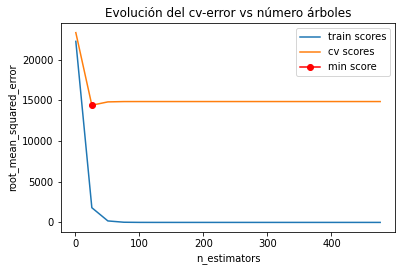

In [46]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
train_scores = []
cv_scores    = []

#valores evaluados
estimator_range = range(1, 500, 25)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.
for n_estimators in estimator_range:
     xgb_reg = GradientBoostingRegressor(
                n_estimators = n_estimators,
                loss = 'ls',
                max_features  = 'auto',
                random_state  = 123
                )    
 # Error de train
     xgb_reg.fit(X_train, y_train)
     predicciones = xgb_reg.predict(X = X_train)
     rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
            squared = False
            )
     train_scores.append(rmse)  
    
# Error de validación cruzada
     scores = cross_val_score(
                estimator = xgb_reg,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5,
                n_jobs    = multiprocessing.cpu_count() - 1,
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
     cv_scores.append(-1*scores.mean())  
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmin(cv_scores)]}")  

Los valores estimados por validación cruzada muestran que se consigue un mínimo con 26 árboles

#### Learning rate

Junto con el número de árboles, el learning_rate es de los hiperparámetros más importantes en Gradient Boosting, ya que es el que permite controlar cómo de rápido aprende el modelo y con ello el riesgo de llegar al overfitting. Estos dos hiperparámetros son interdependientes, cuanto menor es el learning rate, más árboles se necesitan para alcanzar buenos resultados pero menor es el riesgo de overfitting.

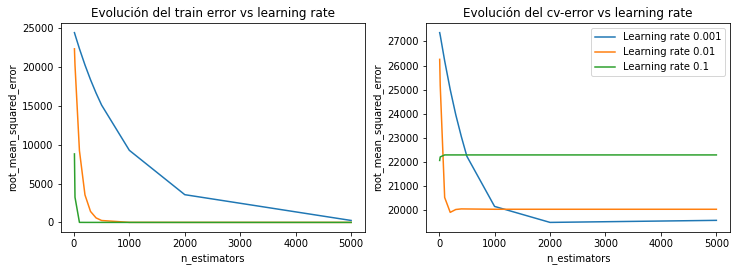

In [47]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
resultados = {}

# Valores evaluados
learning_rates = [0.001, 0.01, 0.1]
n_estimators   = [10, 20, 100, 200, 300, 400, 500, 1000, 2000, 5000]


# Bucle para entrenar un modelo con cada combinacion de  learning_rate y n_estimator 
# y extraer su error de entrenamiento y k-cross-validation.
for learning_rate in learning_rates:
    train_scores = []
    cv_scores    = []
    
    for n_estimator in n_estimators:
    
        xgb_reg = GradientBoostingRegressor(
                    n_estimators  = n_estimator,
                    learning_rate = learning_rate,
                    loss          = 'ls',
                    max_features  = 'auto',
                    random_state  = 123
                 )

        # Error de train
        xgb_reg.fit(X_train, y_train)
        predicciones = xgb_reg.predict(X = X_train)
        rmse = mean_squared_error(
                y_true  = y_train,
                y_pred  = predicciones,
                squared = False
               )
        train_scores.append(rmse)

        # Error de validación cruzada
        scores = cross_val_score(
                    estimator = xgb_reg,
                    X         = X_train,
                    y         = y_train,
                    scoring   = 'neg_root_mean_squared_error',
                    cv        = 3,
                    n_jobs    = multiprocessing.cpu_count() - 1
                 )
        # Se agregan los scores de cross_val_score() y se pasa a positivo
        cv_scores.append(-1*scores.mean())
        
    resultados[learning_rate] = {'train_scores': train_scores, 'cv_scores': cv_scores}

# Gráfico con la evolución de los errores de entrenamiento
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 3.84))

for key, value in resultados.items():
    axs[0].plot(n_estimators, value['train_scores'], label=f"Learning rate {key}")
    axs[0].set_ylabel("root_mean_squared_error")
    axs[0].set_xlabel("n_estimators")
    axs[0].set_title("Evolución del train error vs learning rate")
    
    axs[1].plot(n_estimators, value['cv_scores'], label=f"Learning rate {key}")
    axs[1].set_ylabel("root_mean_squared_error")
    axs[1].set_xlabel("n_estimators")
    axs[1].set_title("Evolución del cv-error vs learning rate")
    plt.legend();

#### Max Depth


La profundidad de los árboles (max_depth) en los modelos Gradient Boosting suele ser un valor muy bajo, haciendo así que cada árbol solo pueda aprender un pequeña parte de la relación entre predictores y variable respuesta (weak learner).

Valor óptimo de max_depth: 1


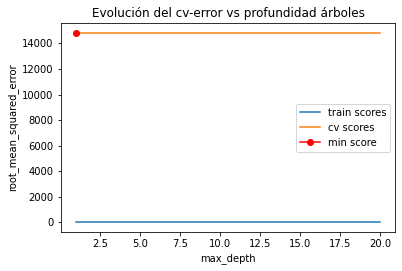

In [48]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
max_depths = [1, 3, 5, 10, 20]

# Bucle para entrenar un modelo con cada valor de max_depth y extraer su error
# de entrenamiento y de k-cross-validation.
for max_depth in max_depths:
    
    modelo = GradientBoostingRegressor(
                n_estimators = 26,
                loss         = 'ls',
                max_depth    = max_depth,
                max_features = 'auto',
                random_state = 123
             )
    
    # Error de train
    xgb_reg.fit(X_train, y_train)
    predicciones = xgb_reg.predict(X = X_train)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = xgb_reg,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5,
                n_jobs    = multiprocessing.cpu_count() - 1
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_depths, train_scores, label="train scores")
ax.plot(max_depths, cv_scores, label="cv scores")
ax.plot(max_depths[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("max_depth")
ax.set_title("Evolución del cv-error vs profundidad árboles")
plt.legend();
print(f"Valor óptimo de max_depth: {max_depths[np.argmin(cv_scores)]}")

Aunque el análisis individual de los hiperparámetros es útil para entender su impacto en el modelo e identificar rangos de interés, la búsqueda final no debe hacerse de forma secuencial, ya que cada hiperparámetro interacciona con los demás. Es preferible recurrir a grid search o random search para analizar varias combinaciones de hiperparámetros.

#### GridSearch

Vamos a utilizar la estrategia GridSearch, es decir, incluiremos varios
parámetros en el grid. Sin embargo, no incluiremos el nº de árboles como hemos 
hecho antes, en este caso pondremos un valor elevado y le pasaremos una parada
temprana.

In [49]:
#Primera parte: Grid de hiperparámetros evaluados

param_grid = {'max_features'  : ['auto', 'sqrt', 'log2'],
              'max_depth'     : [None, 1, 3, 5, 10, 20],
              'subsample'     : [0.5, 1],
              'learning_rate' : [0.001, 0.01, 0.1]
             }

# Segunda parte: Búsqueda por grid search con validación cruzada

grid = GridSearchCV(
        estimator  = GradientBoostingRegressor(
                        n_estimators        = 1000, 
                        random_state        = 123,
                        # Early_stopping
                        validation_fraction = 0.1,
                        n_iter_no_change    = 5,
                        tol                 = 0.0001
                    ),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Tercera Parte: Resultados

resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_learning_rate,param_max_depth,param_max_features,param_subsample,mean_test_score,std_test_score,mean_train_score,std_train_score
79,0.1,1,auto,1,-17479.097623,2197.171977,-8323.831202,4239.060181
43,0.01,1,auto,1,-18427.425515,2956.825938,-10594.631061,5368.768754
85,0.1,3,auto,1,-19064.801986,4849.232521,-7561.110800,4766.676518
91,0.1,5,auto,1,-20100.606712,4997.567475,-8100.241977,5555.044211


In [50]:
# Mejores hiperparámetros obtenidos por validación cruzada
 
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'learning_rate': 0.1, 'max_depth': 1, 'max_features': 'auto', 'subsample': 1} : -17479.097622892823 neg_root_mean_squared_error


Hemos inlcuido 1000 árboles, pero el entrenamiento puede haberse detenido antes,
veremos en qué punto a continuación.

In [51]:
# Número de árboles del modelo final (early stopping)

print(f"Número de árboles del modelo: {grid.best_estimator_.n_estimators_}")

Número de árboles del modelo: 69


Ahora que ya sabemos cuales són los mejores hiperpárametros para el modelo lo entrenamos de nuevo con esos parámetros.

In [52]:
# Error de test del modelo final

xgb_reg_final = grid.best_estimator_
predicciones = xgb_reg_final.predict(X = X_test)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 7682.142896069201


Anteriormente, el valor del rmse con XGBoost sin modificar los parámetros por defecto era de 20.125.  

Ahora, obteniendo los valores óptimos por validación cruzada con el logaritmo de GradientBoostingRegressor hemos conseguido reducirla a 7.682 

Obteniendo esta gran reducción del error vamos a realizar la misma estrategia, pero con el algoritmo XGBoost. Para este caso, sí que tendremos que separar nosotros un porcentaje del dataset para utilizarlo de conjunto de validación para la parada temprana. 

#### XGBoost

In [53]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'max_depth'        : [None, 1, 3, 5, 10, 20],
              'subsample'        : [0.5, 1],
              'learning_rate'    : [0.001, 0.01, 0.1],
              'booster'          : ['gbtree']
             }


# Crear conjunto de validación
# ==============================================================================
np.random.seed(123)
idx_validacion = np.random.choice(
                    X_train.shape[0],
                    size= int(X_train.shape[0]*0.1),
                    replace=False
                 )

X_val = X_train.iloc[idx_validacion, :].copy()
y_val = y_train.iloc[idx_validacion].copy()

X_train_grid = X_train.reset_index(drop = True).drop(idx_validacion, axis = 0).copy()
y_train_grid = y_train.reset_index(drop = True).drop(idx_validacion, axis = 0).copy()

# XGBoost necesita pasar los paramétros específicos del entrenamiento al llamar
# al método .fit()
fit_params = {"early_stopping_rounds" : 5, 
              "eval_metric"           : "rmse", 
              "eval_set"              : [(X_val, y_val)],
              "verbose"               : 0
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = XGBRegressor(
                        n_estimators = 1000,
                        random_state = 123
                    ),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train_grid, y = y_train_grid, **fit_params)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_booster,param_learning_rate,param_max_depth,param_subsample,mean_test_score,std_test_score,mean_train_score,std_train_score
23,gbtree,0.01,20,1,-14341.249817,2534.913862,-10038.985983,5704.172605
21,gbtree,0.01,10,1,-14341.249817,2534.913862,-10038.985983,5704.172605
19,gbtree,0.01,5,1,-14341.249817,2534.913862,-10038.985983,5704.172605
13,gbtree,0.01,None,1,-14341.249817,2534.913862,-10038.985983,5704.172605


In [54]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

# Número de árboles del modelo final (early stopping)
# ==============================================================================
n_arboles_incluidos = len(grid.best_estimator_.get_booster().get_dump())
print(f"Número de árboles incluidos en el modelo: {n_arboles_incluidos}")

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'booster': 'gbtree', 'learning_rate': 0.01, 'max_depth': None, 'subsample': 1} : -14341.249817155267 neg_root_mean_squared_error
Número de árboles incluidos en el modelo: 1000


In [55]:
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 10192.774207841183


### XGBOOST DIARIO

In [56]:
#importamos las librerías necesarias
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import itertools
import multiprocessing

from dateutil import relativedelta
from monthdelta import monthdelta
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance

In [57]:
#carga de datos
df = pd.read_csv('C:/Users/jorge/El Corte Inglés, S.A/Otb y el master - Documentos/VentaDia 2017-2019.csv',';',parse_dates=True)

df['Fecha Venta'] = pd.to_datetime(df['Fecha Venta'])
df=df.dropna()

#set date as index column. (required in time series)
df = df.set_index('Fecha Venta')

print('Shape of data',df.shape)
print(df.dtypes)
df.head()

Shape of data (1095, 1)
Unidades Vendidas    float64
dtype: object


,Unidades Vendidas
Fecha Venta,
2018-01-01,644.0
2018-02-01,7295.0
2018-03-01,4751.0
2018-04-01,6828.0
2018-05-01,4866.0


In [58]:
#bucle para convertir pasos anteriores de tiempo
valor = 1
    
for sale in range(1,31):
    df['Sale_LastDay'+str(valor)] = df['Unidades Vendidas'].shift(valor)
    valor = valor +1
    

df=df.dropna()
df.head(10)

,Unidades Vendidas,Sale_LastDay1,Sale_LastDay2,Sale_LastDay3,Sale_LastDay4,Sale_LastDay5,Sale_LastDay6,Sale_LastDay7,Sale_LastDay8,Sale_LastDay9,...,Sale_LastDay21,Sale_LastDay22,Sale_LastDay23,Sale_LastDay24,Sale_LastDay25,Sale_LastDay26,Sale_LastDay27,Sale_LastDay28,Sale_LastDay29,Sale_LastDay30
Fecha Venta,,,,,,,,,,,,,,,,,,,,,
2018-01-31,2775.0,5001.0,4199.0,4406.0,1719.0,1676.0,1803.0,962.0,2379.0,1860.0,...,878.0,1943.0,2203.0,2536.0,596.0,4866.0,6828.0,4751.0,7295.0,644.0
2018-01-02,4623.0,2775.0,5001.0,4199.0,4406.0,1719.0,1676.0,1803.0,962.0,2379.0,...,1946.0,878.0,1943.0,2203.0,2536.0,596.0,4866.0,6828.0,4751.0,7295.0
2018-02-02,1235.0,4623.0,2775.0,5001.0,4199.0,4406.0,1719.0,1676.0,1803.0,962.0,...,1891.0,1946.0,878.0,1943.0,2203.0,2536.0,596.0,4866.0,6828.0,4751.0
2018-03-02,1188.0,1235.0,4623.0,2775.0,5001.0,4199.0,4406.0,1719.0,1676.0,1803.0,...,1818.0,1891.0,1946.0,878.0,1943.0,2203.0,2536.0,596.0,4866.0,6828.0
2018-04-02,2545.0,1188.0,1235.0,4623.0,2775.0,5001.0,4199.0,4406.0,1719.0,1676.0,...,1852.0,1818.0,1891.0,1946.0,878.0,1943.0,2203.0,2536.0,596.0,4866.0
2018-05-02,2368.0,2545.0,1188.0,1235.0,4623.0,2775.0,5001.0,4199.0,4406.0,1719.0,...,2019.0,1852.0,1818.0,1891.0,1946.0,878.0,1943.0,2203.0,2536.0,596.0
2018-06-02,2980.0,2368.0,2545.0,1188.0,1235.0,4623.0,2775.0,5001.0,4199.0,4406.0,...,2895.0,2019.0,1852.0,1818.0,1891.0,1946.0,878.0,1943.0,2203.0,2536.0
2018-07-02,1543.0,2980.0,2368.0,2545.0,1188.0,1235.0,4623.0,2775.0,5001.0,4199.0,...,1273.0,2895.0,2019.0,1852.0,1818.0,1891.0,1946.0,878.0,1943.0,2203.0
2018-08-02,2164.0,1543.0,2980.0,2368.0,2545.0,1188.0,1235.0,4623.0,2775.0,5001.0,...,2257.0,1273.0,2895.0,2019.0,1852.0,1818.0,1891.0,1946.0,878.0,1943.0


In [59]:
#final_x = np.array(y)
#valor = 1
#for c in range(0,30):
#    X = 'x' + str(valor)
#    #print(X)
#    X = df['Sale_LastDay' + str(valor)]
##    X = np.array(X)
 #   X = X.reshape(-1,1)
#    final_x = np.concatenate([X],axis=1)
    
#    valor = valor + 1
    
#print(final_x)    

In [60]:
#guardamos columnas en variables
x1,x2,x3,x4,x5,= df['Sale_LastDay1'], df['Sale_LastDay2'], df['Sale_LastDay3'],df['Sale_LastDay4'],df['Sale_LastDay5']
x6,x7,x8,x9,x10,x11 = df['Sale_LastDay6'], df['Sale_LastDay7'], df['Sale_LastDay8'],df['Sale_LastDay9'],df['Sale_LastDay10'],df['Sale_LastDay11']
x12,x13,x14,x15,x16 = df['Sale_LastDay12'],df['Sale_LastDay13'],df['Sale_LastDay14'],df['Sale_LastDay15'],df['Sale_LastDay16']
x17,x18,x19,x20,x21 = df['Sale_LastDay17'],df['Sale_LastDay18'],df['Sale_LastDay19'],df['Sale_LastDay20'],df['Sale_LastDay21']
x22,x23,x24,x25,x26 = df['Sale_LastDay22'],df['Sale_LastDay23'],df['Sale_LastDay24'],df['Sale_LastDay25'],df['Sale_LastDay26']
x27,x28,x29,x30,y = df['Sale_LastDay27'],df['Sale_LastDay28'],df['Sale_LastDay29'],df['Sale_LastDay30'],df['Unidades Vendidas']

#convertimos las variables en arrays
x1,x2,x3,x4,x5,=np.array(x1),np.array(x2),np.array(x3),np.array(x4),np.array(x5)
x6,x7,x8,x9,x10,x11 =np.array(x6),np.array(x7),np.array(x8),np.array(x9),np.array(x10),np.array(x11)
x12,x13,x14,x15,x16 = np.array(x12),np.array(x13),np.array(x14),np.array(x15),np.array(x16),
x17,x18,x19,x20,x21 = np.array(x17),np.array(x18),np.array(x19),np.array(x20),np.array(x21),
x22,x23,x24,x25,x26 = np.array(x22),np.array(x23),np.array(x24),np.array(x25),np.array(x26),
x27,x28,x29,x30,y = np.array(x27),np.array(x28),np.array(x29),np.array(x30),np.array(y)

x1,x2,x3,x4,x5,=x1.reshape(-1,1),x2.reshape(-1,1),x3.reshape(-1,1),x4.reshape(-1,1),x5.reshape(-1,1)
x6,x7,x8,x9,x10,x11 =x6.reshape(-1,1),x7.reshape(-1,1),x8.reshape(-1,1),x9.reshape(-1,1),x10.reshape(-1,1),x11.reshape(-1,1)
x12,x13,x14,x15,x16 = x12.reshape(-1,1),x13.reshape(-1,1),x14.reshape(-1,1),x15.reshape(-1,1),x16.reshape(-1,1),
x17,x18,x19,x20,x21 = x17.reshape(-1,1),x18.reshape(-1,1),x19.reshape(-1,1),x20.reshape(-1,1),x21.reshape(-1,1),
x22,x23,x24,x25,x26 = x22.reshape(-1,1),x23.reshape(-1,1),x24.reshape(-1,1),x25.reshape(-1,1),x26.reshape(-1,1),
x27,x28,x29,x30,y = x27.reshape(-1,1),x28.reshape(-1,1),x29.reshape(-1,1),x30.reshape(-1,1),y.reshape(-1,1)

#creamos la matriz
final_x=np.concatenate((x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30),axis=1)                                                                                                           

print(final_x)

print(final_x.shape)




[[5001. 4199. 4406. ... 4751. 7295.  644.]
 [2775. 5001. 4199. ... 6828. 4751. 7295.]
 [4623. 2775. 5001. ... 4866. 6828. 4751.]
 ...
 [5447. 5051. 4592. ... 1877. 1239.  879.]
 [5399. 5447. 5051. ... 2699. 1877. 1239.]
 [5658. 5399. 5447. ... 1031. 2699. 1877.]]
(1065, 30)


In [61]:
#División de los datos entre train y test
#usaremos train_test_split para ello.

#X = df.iloc[:, 1:] 
#y = df.iloc[:,0]
X = df.iloc[:, 0:-1] 
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state=123)

In [62]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'max_depth'        : [None, 1, 3, 5, 10, 20],
              'subsample'        : [0.5, 1],
              'learning_rate'    : [0.001, 0.01, 0.1],
              'booster'          : ['gbtree']
             }


# Crear conjunto de validación
# ==============================================================================
np.random.seed(123)
idx_validacion = np.random.choice(
                    X_train.shape[0],
                    size= int(X_train.shape[0]*0.1),
                    replace=False
                 )

X_val = X_train.iloc[idx_validacion, :].copy()
y_val = y_train.iloc[idx_validacion].copy()

X_train_grid = X_train.reset_index(drop = True).drop(idx_validacion, axis = 0).copy()
y_train_grid = y_train.reset_index(drop = True).drop(idx_validacion, axis = 0).copy()

# XGBoost necesita pasar los paramétros específicos del entrenamiento al llamar
# al método .fit()
fit_params = {"early_stopping_rounds" : 5, 
              "eval_metric"           : "rmse", 
              "eval_set"              : [(X_val, y_val)],
              "verbose"               : 0
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = XGBRegressor(
                        n_estimators = 1000,
                        random_state = 123
                    ),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train_grid, y = y_train_grid, **fit_params)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_booster,param_learning_rate,param_max_depth,param_subsample,mean_test_score,std_test_score,mean_train_score,std_train_score
28,gbtree,0.1,3,0.5,-1548.480665,350.123554,-967.731055,209.142599
17,gbtree,0.01,3,1,-1558.002397,363.374065,-822.261376,98.472265
29,gbtree,0.1,3,1,-1565.533114,342.700198,-773.903721,86.450087
34,gbtree,0.1,20,0.5,-1572.432911,343.885690,-812.081133,207.609419


In [63]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

# Número de árboles del modelo final (early stopping)
# ==============================================================================
n_arboles_incluidos = len(grid.best_estimator_.get_booster().get_dump())
print(f"Número de árboles incluidos en el modelo: {n_arboles_incluidos}")

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.5} : -1548.480665406825 neg_root_mean_squared_error
Número de árboles incluidos en el modelo: 40


In [64]:
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 1050.1059361956516
